# Representations and Computation of Traffic Quantities from Trajectories

As in any field, there are multiple ways in which we can represent the traffic state and its evolution over time. In traffic flow, the primary source information or "raw data" is related to kinematic variables associated to each driver such as position, speed, and acceleration. However, this information is not straightforward to interpret by looking into a set of trajectories of different vehicles. This notebook presents some common way to represent traffic data and how to compute basic quantities such as flow rate and volume from trajectories data.

# Dependencies and opening the data set

For this project we will need the numpy for handling the vectors data, pylab for plotting graphs. For this specific examples, we are using a vehicle trajectories that was generated using microsimulation that is saved as a csv file in which we load it into a pandas dataframe: 

In [153]:
import numpy
import pandas
import pylab

from operator import itemgetter

ds = pandas.read_csv('vehicleTrajectories.csv')
print(ds.head(60))

    VID  Elapsed  TIME  Lane  CFNODEID  CENODEID  CLINKID    Coord_x  \
0    62        2  60.0     1         1         2        1    894.884   
1    57        2  60.0     1         1         2        1    848.321   
2    60        2  60.0     2         1         2        1    903.570   
3    64        2  60.0     2         1         2        1    824.188   
4    58        2  60.0     2         1         2        1    783.941   
5    61        2  60.0     2         1         2        1    748.591   
6    56        2  60.0     3         1         2        1    932.814   
7    59        2  60.0     3         1         2        1    815.314   
8    33        2  60.0     1         2         3        3   1934.140   
9    31        2  60.0     1         2         3        3   1889.420   
10   34        2  60.0     1         2         3        3   1816.470   
11   36        2  60.0     1         2         3        3   1747.210   
12   43        2  60.0     1         2         3        3   1694

The vehicle trajectories is a set of rows such as the few of them printed above. The field names is specific to Paramics microsimulator, but any data set either coming from simulated trajectories or actual data will have similar fields. Each row represents a data sample of one vehicle (VID) at a specific time (TIME). At this time that vehicle is in a specific link (CLinkID), lane (Lane), a position along the link (Link_TDist), at a specific coordinates (x,y), and traveling at a certain speed (Spd). These are the information that we will use for the following computation.

It is also necessary information of the road network in which the trajectory information is coming from. It can be either in a separeted file or provide externally. In the case of this data set it refers to an unidirectional freeway and the network is defined in code. Also, it is also defined a function to return the distance from the start link (1) along the freeway. 

In [1]:
link_sequence = [1,3,5,7,9,11,13,15,17,19]
link_distances = {1: 367.8897, 3: 1088.525195, 5: 1036.50416, 7: 551.186, 9: 137.945846849, 11: 339.99402000360004, 
                  13: 339.98843000000005, 15: 801.400873966, 17: 770.1804050000001, 19: 135.62900499999998}

def get_cumulative_distance(link, pos):
    iter_index = 0
    distance_traveled = 0
    
    for link_id in link_sequence:
        if link_id==link:
            break
        distance_traveled = distance_traveled + link_distances[link_id]
    
    #add the distance traveled on the link
    return distance_traveled+pos

print(get_cumulative_distance(19, 135)
     )

5568.6146308186


Observe the last call is the end of the freeway (position 135m) of the last link so in our case we have a freeway of 5568m.

# Space-time diagrams

The simplest way to depict trajectories is a space-time diagram where each line represents the trajectory of one vehicle along the freeway. For that we need to have the trajectories of every vehicle in order to plot it. In this case, we need to group the trajectories by vehicle id (as the data set is quite large, it may take a while to rn the part below).

In [251]:
vehicle_ids = []
time_entered = []
vehicles = {}

print(list(ds))

for index, row in ds.iterrows():
    if row['VID'] not in vehicles:
        vehicles[int(row['VID'])] = []
        vehicle_ids.append(int(row['VID']))
        time_entered.append(row['TIME'])
    
    position = get_cumulative_distance(int(row['CLINKID']), row['Link_TDist'])
    row_info = {'time':row['TIME'],'position': position ,'lane':int(row['Lane']), 'speed': row['Spd']}
    vehicles[int(row['VID'])].append(row_info)

print("starting to sort")
for vehicle_id in vehicles:
    sort_traj = sorted(vehicles[vehicle_id], key=itemgetter('time'))
    vehicles[vehicle_id] = sort_traj
print("sorted")    

print(vehicle_ids[0:15])
print(vehicles[vehicle_ids[1]][0:5])

['VID', 'Elapsed', 'TIME', 'Lane', 'CFNODEID', 'CENODEID', 'CLINKID', '  Coord_x', ' Coord_y', ' Travel_Dist', 'Link_TDist', 'Spd', ' Detected']
starting to sort
sorted
[62, 57, 60, 64, 58, 61, 56, 59, 33, 31, 34, 36, 43, 39, 41]
[{'time': 60.0, 'position': 256.03500000000003, 'lane': 1, 'speed': 16.302900000000001}, {'time': 60.5, 'position': 264.471, 'lane': 1, 'speed': 17.440999999999999}, {'time': 61.0, 'position': 273.50400000000002, 'lane': 1, 'speed': 18.690999999999999}, {'time': 61.5, 'position': 283.16200000000003, 'lane': 1, 'speed': 19.940999999999999}, {'time': 62.0, 'position': 293.44499999999999, 'lane': 1, 'speed': 21.190999999999999}]


Now we have the ids of all vehicles (vehicle_ids) in the order as they were first observed. In variable time_entered we have also the instant of the first sample associated with that vehicle. In the following piece of code, the trajectories of the 1st to 200th element of vehicle is depicted. We first need to define each trajectorie based on time and position of each vehicle and then plot it: 

1 367.8897
3 1456.414895
5 2492.919055
7 3044.105055
9 3182.050901849
11 3522.0449218526
13 3862.0333518526
15 4663.4342258186
17 5433.6146308186
19 5569.2436358186
3722.0449218526


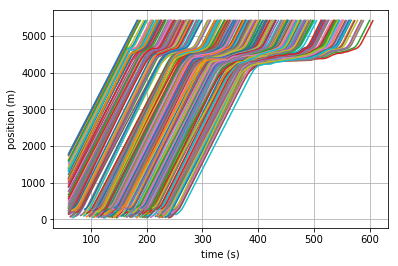

In [290]:
ids_to_depict = vehicle_ids[0:200]

for vehicle_id in ids_to_depict:
    times = [sample['time'] for sample in vehicles[vehicle_id] ]
    positions = [sample['position'] for sample in vehicles[vehicle_id]]
    
    last_position = 0
    
    for el in positions:
        if el < last_position:
            pass
            #print("backward", position)
        
        last_position = el
    
    
    pylab.plot(times, positions)


cums = 0
for l_id in link_sequence:
    cums = cums + link_distances[l_id]
    print(l_id, cums)

print(get_cumulative_distance(13,200))
    
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.grid(True)
pylab.show()

These are the complete trajectories of 100 vehicles. We can also just select the samples from position $3500m$ to $5000m$ to see more in detail the change of speed that happens around that time.

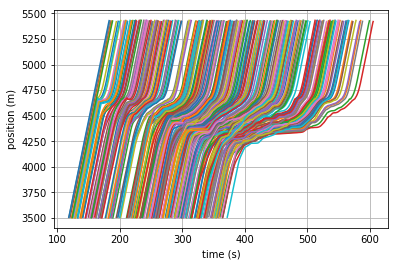

In [291]:
for vehicle_id in ids_to_depict:
    times = [sample['time'] for sample in vehicles[vehicle_id] if sample['position'] > 3500 ]
    positions = [sample['position'] for sample in vehicles[vehicle_id] if sample['position'] > 3500  ]
    
    pylab.plot(times, positions)

pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.grid(True)
pylab.show()


What is happening in this example is that there is a bottleneck around the position 4700m and vehicles is slowing down at that area. Also observe that some lines intersect each other. It means that vehicles at different lanes have different speeds and vehicles are passing each other. 

We can also depict the vehicles lane in this 2D graph by perfoming a small trick on the x-axis. As the number of lanes is a small quantity (5 at most), we can extended the time-axis to carry lane information as well. In the previous example, the last sample is around 600s. We can represent vehicles at lane 1 on the graph on the interval (0,600), on lane 2 in the interval (600,1200), and lane 3 in the interval (1200, 1800) where for example, a sample with value 1250 means time $50$ at lane 3. Then we can label the x-axis accordingly. 

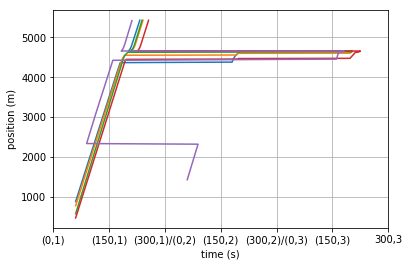

In [158]:
ids_to_depict = vehicle_ids[15:20]

def lanetime_to_coord_x(t, lane):
    return 300*(lane-1)+t

for vehicle_id in ids_to_depict:
    times = [lanetime_to_coord_x(sample['time'], sample['lane']) for sample in vehicles[vehicle_id] ]
    positions = [sample['position'] for sample in vehicles[vehicle_id]]
    
    pylab.plot(times, positions)

pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.grid(True)
pylab.xticks([0,150,300,450,600,750,900],["(0,1)","(150,1)", "(300,1)/(0,2)", "(150,2)", "(300,2)/(0,3)","(150,3)",("300,3")])
pylab.show()

See that the time (x-axis) is shifted by 300mfor each lane. In this case we can observe the lane changes for each of the depicted vehicles. With the xticks we can "say" that the $t=450$ actually is not $t=450s$, but it is the $t=150m$ of lane 2 and so on. 

# Aggregated Representations

Most of the times we are not concerned with the trajectories of individual vehicles, but rather with aggregated variables such as space mean speed, flows and densities. That is what we are going to do next. The simplest one is flow over a period at a specific point defined as the number of vehicles that crossed that point.

The code below computes the flows and times at steps of 50m and 5s. With that information we can compute various other quantities later.

number of cells 57
steps 350


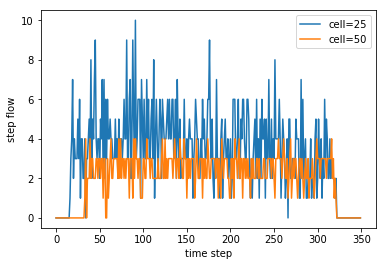

In [289]:
step_length = 100
positions = [step_length*i for i in range(int(5650/step_length)+1)]
total_cells = len(positions)
print("number of cells", total_cells)

time_step = 5
num_steps = 350
times = [time_step*i for i in range(num_steps)]
print("steps", num_steps)

flows = {}
for k in range(len(positions)):
    flows[k] = [0.0 for i in range(num_steps)]

for vehicle_id in vehicles:
    last_pos = vehicles[vehicle_id][0]['position']
    
    
    for dic_value in vehicles[vehicle_id][1:]:
        
        if dic_value['position'] < last_pos:
            continue
        
        k_current = int(dic_value['position']/step_length)
        
        k_last = int(last_pos/step_length)
              
        
        last_pos = dic_value['position']
        
        if k_current == k_last+1:
            k_counted.append(k_current)
            step = int(dic_value['time']/time_step)
            
            flows[k_current][step] = flows[k_current][step] + 1    
        
    
pylab.plot(flows[25], label="cell=25")
pylab.plot(flows[50], label="cell=50")
pylab.xlabel("time step")
pylab.ylabel("step flow")
pylab.legend(loc=1)
pylab.show()


At every 50m point we have computed the flow over time. The previous picture depicts the flow at the 50th cell (therefore at 2500m) at different time steps (each time step is 5 seconds). A common way to represent flows over time and space is through the cumulative counts. If we denote flows at step $t$ at location $x$ as $q(x,t)$, the cumulative count $N(x,t)$ is computed as:

$$ N(x,t) = \sum_{\tau=0}^{t} q(x,\tau) $$

Therefore it is straighforward to compute the cumulative flows from the flow that we have just computed. The following code computes the cumulative counts at all location and times and stores it in a 2D array.

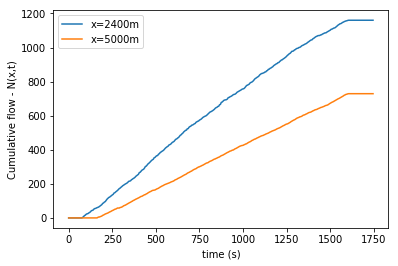

In [283]:
cumulatives = numpy.empty([total_cells, num_steps])

for k in range(total_cells):
    cum = 0
    
    for t in range(num_steps):
        cum = cum + flows[k][t]
        cumulatives[k,t] = cum

pylab.plot(times, cumulatives[24,:], label="x="+str(2400)+"m")
pylab.plot(times, cumulatives[50,:], label="x="+str(5000)+"m")
pylab.xlabel("time (s)")
pylab.ylabel("Cumulative flow - N(x,t)")
pylab.legend(loc=2)
pylab.show()




We can plot a complete surface over all locations as the 3D or Makigami representation of traffic flow:

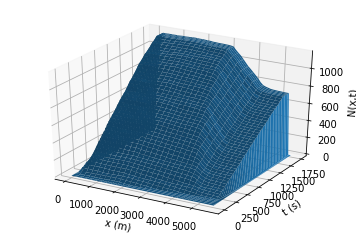

In [284]:
from mpl_toolkits import mplot3d

pos_2d = numpy.empty(cumulatives.shape)
time_2d = numpy.empty(cumulatives.shape)

for k in range(total_cells):
    for t in range(num_steps):
        pos_2d[k,t] = positions[k]
        time_2d[k,t] = times[t]

fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')

# Make data.
surf = ax.plot_surface(pos_2d, time_2d, cumulatives)

ax.set_xlabel('x (m)')
ax.set_ylabel('t (s)')
ax.set_zlabel('N(x,t)')

pylab.show()

The 3D representation is very interesting as we can observe the state of the whole freeway in the sameplot. As we know from the time-space (above) diagram there is a bottleneck that there is some congestion starts around $x=5000$m. We can see the congestion arising in time and space. The corners of this surface is associated of where vehicles starts to slow down (see the line that starts at $t=250$ and $x=5000m$ that at $t=1750m$ is at a different location. We can see at the bottleneck the cumulative count at a specific $x$ roughly grows linearly. 

In this case in which there is no on- and off-ramps, the number of vehicles between position $x_1$ and $x_2$ at time $t$, denote as $n(x_1, x_2,t)$ can be computed as:

$$n(x_1, x_2, t) = N(x_1, t)-N(x_2,t)$$

and at the same coordinates we can compute the density $k$ as:

$$ k(x_1, x_2, t) = \frac{n(x_1, x_2, t)}{x_2-x_1} $$

So we can compute densities from the cumulative counts that we already have:

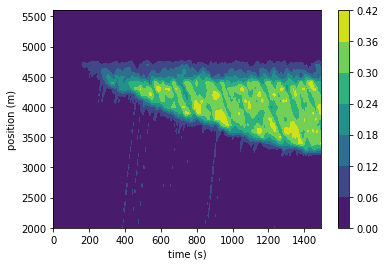

In [285]:
densities = numpy.zeros([total_cells-1, num_steps])


for k in range(total_cells-4):
    densities[k,:] = (cumulatives[k,:]-cumulatives[k+1,:])/step_length

f = pylab.figure()
cp = pylab.contourf(time_2d[20:,:300], pos_2d[20:,:300], densities[19:,:300]) #for some reason is yielding 10x times bigger
pylab.colorbar(cp)
pylab.xlabel('time (s)')
pylab.ylabel('position (m)')

pylab.show()

We have computed density, $k$, and flow, $q$, over time and space in the previous example. The following identity always holds for traffic flow:

$$ q = k v $$,

therefore we can compute the speed as $v=\frac{q}{k}$ at every time step and at every position (cell). The following part computes the speeds and the result is depicted in a contour plot. The speed is also bound by a maximum speed as some samples have unreasonably high speeds which comes from the way we are computing densities (at specific time-steps) and flows (total flow during the time step). Later we compute the same measurements through Edie's definition and we don't need to worry about that.

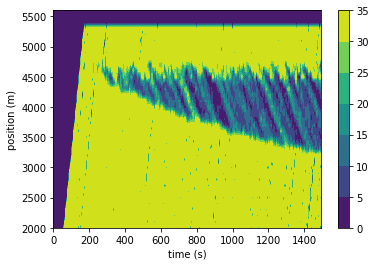

In [306]:
speeds = numpy.zeros([total_cells-1, num_steps])
MAX_SPEED = 35

for k in range(total_cells-4):
    for t in range(num_steps):
        
        if densities[k,t] > 0.0:
            speeds[k,t] = flows[k][t]/densities[k,t]

        if speeds[k,t] > MAX_SPEED:
            speeds[k,t] = MAX_SPEED
            
f = pylab.figure()
cp = pylab.contourf(time_2d[20:,:300], pos_2d[20:,:300], speeds[19:,:300]) #for some reason is yielding 10x times bigger
pylab.colorbar(cp)
pylab.xlabel('time (s)')
pylab.ylabel('position (m)')

pylab.show()

# Occupancies and Eddie's definition of density

In the last example he density was computed based on the number of vehicles between two points at a specific time step. In that case, all the information related to density in between the steps is lost as we have information at discrete times.

However, we can estimate as continuous time variable if we assume vehicles travels at constant speed between time steps by using Eddie's definition of density and flows. The concept can be generalizable to any area in the space-time domain, but here we are interested in computing traffic flow variables between times $t_1$ and $t_2$ and positions $x_1$ and $x_2$. In this domain, we need to identify the vehicles $i$ which that was inside this domain. For each vehicle we compute the time inside the region, $t_1$ and distance traveled along the region, $d_i$ as:

$$ k = \frac{\sum_{\forall i} t_i}{(x_2-x_1)(t_2-t_1)}$$
$$ q = \frac{\sum_{\forall i} d_i}{(x_2-x_1)(t_2-t_1)}$$

In the next example the density and flows  between $x_1=4000m$ and $x_2=4005m$ with steps of $5$s is computed and plotted. 

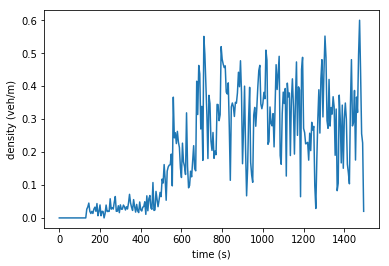

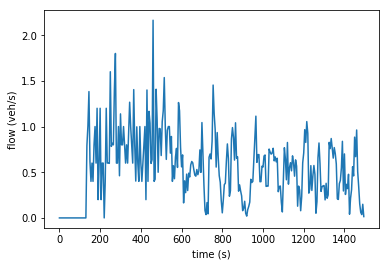

In [293]:
num_steps = 300
t_step = 5
total_xis = [0.0 for _ in range(num_steps)]
total_tis = [0.0 for _ in range(num_steps)]

x_1 = 4000
x_2 = 4005

for vehicle_id in vehicles:
    
    num_samples = len(vehicles[vehicle_id])
    for i in range(1,num_samples):
        sample = vehicles[vehicle_id][i]
        last_sample = vehicles[vehicle_id][i-1]
        
        if sample['time'] > t_step*(num_steps-1):
            continue
        
        if sample['position'] < x_1 or last_sample['position'] > x_2:
            continue
            
        #if reaches here there is some time spent at this is step between x_1 and x_2
        
        if sample['position'] > x_2:
            if last_sample['position'] <= x_1:
                d = x_2-x_1
            else:
                d = x_2-last_sample['position']
        else:
            if last_sample['position'] < x_1:
                d = sample['position']-x_1
            else:
                d = sample['position']-last_sample['position']
        
        
        t_distance = sample['position']-last_sample['position']
        
        if t_distance == 0:
            time_ratio = 1.0
        else:
            time_ratio = d/(sample['position']-last_sample['position'])
        
        t = time_ratio*(sample['time']-last_sample['time'])
        
        step = int(sample['time']/t_step)
        
        total_xis[step] = total_xis[step]+d
        total_tis[step] = total_tis[step]+t

domain_area = t_step*(x_2-x_1)

density = [t/domain_area for t in total_tis]
flow = [x/domain_area for x in total_xis]

pylab.plot([p*t_step for p in range(num_steps)],density)
pylab.xlabel("time (s)")
pylab.ylabel("density (veh/m)")
pylab.show()

pylab.plot([p*t_step for p in range(num_steps)],flow)
pylab.xlabel("time (s)")
pylab.ylabel("flow (veh/s)")
pylab.show()
            

From the total time in that segment, we can also compute the occupancy which is defined as the percentage in a defined period (like the 5 seconds of previous example) of time in which there was at least one vehicle on the area between $x_2$ and $x_1$. The definition of occupancy is:

$$ occ = \frac{t_{on}}{T}$$

where $T$ is the sample time and $t_{on}$ is the amount of time on the period $T$ in which there was at least one vehicle on the top of the detector. For this specific case we assume that $x_2-x_1=5$m is small enough and at each lane only one vehicle is inside that area at a given time. Therefore, we can assume that $t_{on}=\sum_{\forall i}t_i$ in the same way we computed. Following the occupancy is computed and normalized by lane (as there are 3 lanes, it is divided by 3).

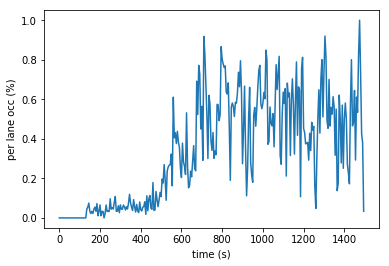

In [294]:
occ = [t/(3*t_step) for t in total_tis]

pylab.plot([p*t_step for p in range(num_steps)], occ)
pylab.xlabel("time (s)")
pylab.ylabel("per lane occ (%)")
pylab.show()

Now we compute again the flow, density and space mean speed using the Eddie's definition.

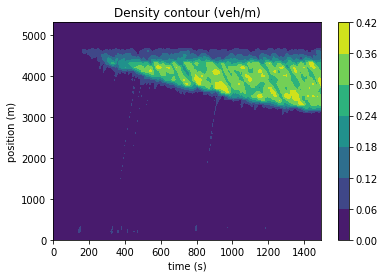

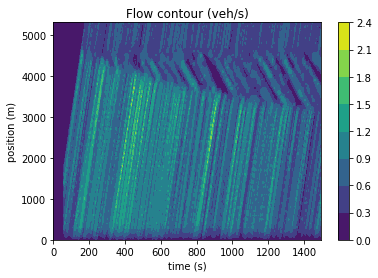

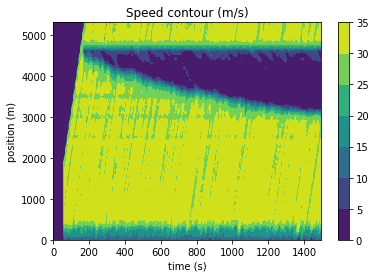

In [322]:
num_steps = 300
step_length = 100
last_position = 5400
num_cells = int(last_position/step_length)
t_step = 5
domainarea = step_length*t_step

total_xis = numpy.zeros([num_cells, num_steps])
total_tis = numpy.zeros([num_cells, num_steps])


for vehicle_id in vehicles:
    
    num_samples = len(vehicles[vehicle_id])
    for i in range(1,num_samples):
        sample = vehicles[vehicle_id][i]
        last_sample = vehicles[vehicle_id][i-1]
        step = int(sample['time']/t_step)
        period = sample['time']-last_sample['time']
        distance = sample['position']-last_sample['position']
        
        if sample['position'] >= last_position or step >= num_steps:
            break

        sample_cell = int(sample['position']/step_length)
        last_sample_cell = int(sample['position']/step_length)
        
        if sample_cell == last_sample_cell:
            total_tis[sample_cell, step] += period
            total_xis[sample_cell, step] += distance
        else:
            dist_cell = sample['position']-sample*cell*step_length
            dist_previous = distance-dist_cell
            
            time_ratio = dist_cell/distance
            
            total_tis[sample_cell, step] = time_ratio*period
            total_xis[sample_cell, step] = dist_cell
            
            total_tis[last_sample_cell, step] = (1-time_ratio)*period
            total_xis[last_sample_cell, step] = dist_previous

            
pos_2d = numpy.empty(total_tis.shape)
time_2d = numpy.empty(total_tis.shape)

speed = numpy.zeros(total_tis.shape)

for k in range(num_cells):
    for t in range(num_steps):
        pos_2d[k,t] = k*step_length
        time_2d[k,t] = t*t_step

        if total_tis[k,t] > 0:
            speed[k,t] = total_xis[k,t]/total_tis[k,t]
        
density = total_tis/domainarea
flow = total_xis/domainarea
        
f = pylab.figure()
cp = pylab.contourf(time_2d, pos_2d, density) #for some reason is yielding 10x times bigger
pylab.colorbar(cp)
pylab.title("Density contour (veh/m)")
pylab.xlabel('time (s)')
pylab.ylabel('position (m)')

pylab.show()

f = pylab.figure()
cp = pylab.contourf(time_2d, pos_2d, flow) #for some reason is yielding 10x times bigger
pylab.colorbar(cp)
pylab.xlabel('time (s)')
pylab.ylabel('position (m)')
pylab.title("Flow contour (veh/s)")

pylab.show()

f = pylab.figure()
cp = pylab.contourf(time_2d, pos_2d, speed) #for some reason is yielding 10x times bigger
pylab.colorbar(cp)
pylab.xlabel('time (s)')
pylab.ylabel('position (m)')
pylab.title("Speed contour (m/s)")

pylab.show()